In [1]:
%matplotlib inline

import os
import re
import pandas as pd
import numpy as np
import zipfile as zipfile
import shutil
import random
from pathlib import Path

from fastai.vision import *
from fastai.metrics import error_rate

In [2]:
files = zipfile.ZipFile("dataset-resized.zip",'r')
files.extractall()
files.close()

KeyboardInterrupt: 

In [4]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['.DS_Store', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [3]:
#returns a split between test, valid, and train indices for the input folder
def splitDataIndices(folder,trainSplit):    
    n = len(os.listdir(folder))
    fullSet = list(range(1,n+1))

    #train indices
    random.seed()
    train = random.sample(list(range(1,n+1)),int(trainSplit*n))
    remain = list(set(fullSet)-set(train))

    #rest of the data is split between valid and test
    random.seed()
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return (train,valid,test)

In [4]:
#get file names for the given indices
def getNames(trashType, indices):
    names = [f"{trashType}{str(i)}.jpg" for i in indices]
    return(names)    

#moves source files to destination folder
def moveFiles(sourceFiles,destination):
    for f in sourceFiles:
        shutil.move(f,destination)

In [5]:
subsets = ['train','valid']
trashTypes = ['cardboard','plastic','glass','metal','paper','trash']

#create destination folders for data subset and waste type
for subset in subsets:
    for trash in trashTypes:
        folder = os.path.join('data',subset,trash)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
#move files to destination folders for each trash type
for trash in trashTypes:
    fullDataFolder = os.path.join('dataset-resized',trash)
    traini, validi, testi = splitDataIndices(fullDataFolder,0.6)
    
    trainNames = getNames(trash,traini)
    train_source_files = [os.path.join(fullDataFolder,name) for name in trainNames]
    moveFiles(train_source_files,"data/train/"+trash)
    
    validNames = getNames(trash,validi)
    valid_source_files = [os.path.join(fullDataFolder,name) for name in validNames]
    moveFiles(valid_source_files,"data/valid/"+trash)
    
    testNames = getNames(trash,testi)
    test_source_files = [os.path.join(fullDataFolder,name) for name in testNames]
    moveFiles(test_source_files,"data/test")

In [7]:
path = Path(os.getcwd())/"data"
path

WindowsPath('C:/Users/4euge/SysLab/data')

In [8]:
#tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",bs=16)

In [9]:
print(data)
print(data.classes)

ImageDataBunch;

Train: LabelList (1514 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
cardboard,cardboard,cardboard,cardboard,cardboard
Path: C:\Users\4euge\SysLab\data;

Valid: LabelList (505 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
cardboard,cardboard,cardboard,cardboard,cardboard
Path: C:\Users\4euge\SysLab\data;

Test: LabelList (508 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: C:\Users\4euge\SysLab\data
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [10]:
learner = cnn_learner(data,models.resnet34,metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


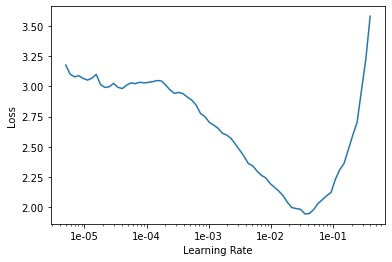

In [12]:
learner.lr_find(start_lr=1e-6,end_lr=1e1)
learner.recorder.plot()

In [21]:
lr_diff = 15
loss_threshold = .05 
adjust_value = 1
plot = False
lrs = learner.recorder.lrs
losses = np.array(learner.recorder.losses)
assert(lr_diff < len(losses))
loss_grad = np.gradient(losses)

r_idx = -1
l_idx = r_idx - lr_diff
while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
    local_min_lr = lrs[l_idx]
    r_idx -= 1
    l_idx -= 1

lr_to_use = local_min_lr * adjust_value
print(lr_to_use)

0.0037153522909717258


In [22]:
learner.fit_one_cycle(20,max_lr=lr_to_use)

epoch,train_loss,valid_loss,error_rate,time
0,1.583049,0.682216,0.255556,32:38
1,0.970610,0.440461,0.141270,1:18:54
2,0.675189,0.453422,0.130159,16:31
3,0.550644,0.594134,0.171429,17:53
4,0.584783,0.582996,0.155556,17:47
5,0.485615,0.632903,0.185714,18:52
6,0.495500,0.657188,0.171429,18:26
7,0.387787,0.610271,0.171429,18:52
8,0.378360,0.500096,0.147619,20:18
9,0.317728,0.598896,0.155556,21:06


In [29]:
learner.export('models/fastai_1.pkl')

In [8]:
learner = load_learner('data/models', 'fastai_1.pkl')

Learner(data=ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data\models;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data\models;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): 

In [7]:
#confusion matrix
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "C:\Users\4euge\anaconda3\lib\site-packages\torch\utils\data\_utils\worker.py", line 185, in _worker_loop
    data = fetcher.fetch(index)
  File "C:\Users\4euge\anaconda3\lib\site-packages\torch\utils\data\_utils\fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "C:\Users\4euge\anaconda3\lib\site-packages\torch\utils\data\_utils\fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "C:\Users\4euge\anaconda3\lib\site-packages\fastai\data_block.py", line 655, in __getitem__
    if self.item is None: x,y = self.x[idxs],self.y[idxs]
  File "C:\Users\4euge\anaconda3\lib\site-packages\fastai\data_block.py", line 120, in __getitem__
    if isinstance(idxs, Integral): return self.get(idxs)
  File "C:\Users\4euge\anaconda3\lib\site-packages\fastai\vision\data.py", line 270, in get
    fn = super().get(i)
  File "C:\Users\4euge\anaconda3\lib\site-packages\fastai\data_block.py", line 75, in get
    return self.items[i]
IndexError: index 0 is out of bounds for axis 0 with size 0
